In [1]:
#loading the libraries
from tensorflow_probability import distributions as tfd
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Activation, Concatenate

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.datasets import load_boston
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns
import random
import numpy as np
import statsmodels.api as sm
import pickle
from sklearn.feature_selection import mutual_info_regression
from scipy import stats
import rpy2
from scipy.stats import spearmanr,pearsonr
from tensorflow.keras.models import Sequential
from CCIT import CCIT

2022-07-28 14:58:41.441154: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-28 14:58:41.441186: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
#defining the class MDN
class MDN_module(tf.keras.Model):
#changed from 15 to 20
    def __init__(self, neurons=15, components = 1):
        super(MDN_module, self).__init__(name="MDN_module")
        self.neurons = neurons
        self.components = components

        #chaging activation to relu from linear, changin relu to sigmoid 
        for i in range(1,3):
          s="self"+".h"+str(i)+"= Dense(neurons, activation=\"relu\", name="+"'h"+str(i)+"')"
          exec(s)
        self.alphas = Dense(components, activation="softmax", name="alphas")
        self.mus = Dense(components, activation="linear",name="mus") 
        self.sigmas = Dense(components, activation="nnelu",name="sigmas") #activation changed from linear to default
        self.pvec = Concatenate(name="pvec")
        
    def call(self, inputs):
        x=self.h1(inputs)
        #x=self.inputA(inputs)
        x=self.h2(x)
        alpha_v = self.alphas(x)
        mu_v = self.mus(x)
        sigma_v = self.sigmas(x)
        
        return self.pvec([alpha_v,mu_v, sigma_v])

In [3]:
len(A)

NameError: name 'A' is not defined

In [7]:
#loading yeast groundtruth 1 data
yeast=open("../../yeast_full_data/yeast_residual_data_full_62k_gt1.txt","r")



#yeast data read 
L=[]
A=[]
B=[]
#209157
for i in range(0,62296):
    line=yeast.readline()
    #line=line[1:-2] #remove double quotes 
    #param = [j for j in line.split()]
    #print(param)
    #chrname.append(param[1])
    #g1.append(param[2])
    #g2.append(param[3])
    line=yeast.readline()
    l = [j for j in line.split()]
    L.append([int(i) for i in l])
    line=yeast.readline()
    a = [j for j in line.split()]
    A.append([float(i) for i in a])
    line=yeast.readline()
    b = [j for j in line.split()]
    B.append([float(i) for i in b])
dataset_yeast_1 = [i for i in zip(L,A,B)]


In [9]:
dataset_yeast_1[121]

IndexError: list index out of range

In [51]:
model = Sequential()
model.add(Dense(12, input_shape=(1,), activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='linear'))
# compile the keras model
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
# fit the keras model on the dataset
model.fit(A, B, epochs=150, batch_size=10,verbose=0)
# evaluate the keras model
_, accuracy = model.evaluate(A, B)

32/32 [==============================] - 0s 640us/step - loss: 2.3220 - accuracy: 0.0000e+00


In [4]:
plt.scatter(A,B)
plt.scatter(A,model.predict(A))

NameError: name 'A' is not defined

In [50]:
y_pred

1.4015753269195557

In [5]:
no_parameters=3
components=1
def nnelu(input):
    """ Computes the Non-Negative Exponential Linear Unit
    """
    return tf.add(tf.constant(1, dtype=tf.float32), tf.nn.elu(input))

def slice_parameter_vectors(parameter_vector):
    """ Returns an unpacked list of paramter vectors.
    """
    return [parameter_vector[:,i*components:(i+1
    )*components] for i in range(no_parameters)]

def gnll_loss(y, parameter_vector):
    """ Computes the mean negative log-likelihood loss of y given the mixture parameters.
    """
    alpha,mu,sigma = slice_parameter_vectors(parameter_vector) # Unpack parameter vectors
    #tf.print(sigma)
    gm = tfd.MixtureSameFamily(
           mixture_distribution=tfd.Categorical(probs=alpha),
           components_distribution=tfd.Normal(
           loc=mu,       
           scale=sigma))
    
                                    
    
    log_likelihood =  gm.log_prob(tf.transpose(y)) # Evaluate log-probability of y 
    return -tf.reduce_mean(log_likelihood, axis=-1) 

tf.keras.utils.get_custom_objects().update({'nnelu': Activation(nnelu)})

def gnll_eval(y,alpha, mu, sigma):
    """ Computes the mean negative log-likelihood loss of y given the mixture parameters.
    """
    #print(alpha)
    gm = tfd.MixtureSameFamily(
        mixture_distribution=tfd.Categorical(probs=alpha),
        components_distribution=tfd.Normal(
            loc=mu,       
            scale=sigma))
    log_likelihood = gm.log_prob(tf.transpose(y))
    return -tf.reduce_mean(log_likelihood, axis=-1)


def eval_mdn_model(x_test, y_test, mdn_model):
    """ Evaluate the model to get the loss for the given x and y 
    """
    y_pred = mdn_model.predict(np.reshape(x_test,newshape=(len(x_test),-1)))
    alpha,mu,sigma = slice_parameter_vectors(y_pred)
    mdn_nll = gnll_eval(y_test.astype(np.float32),alpha, mu, sigma).numpy()
    return mdn_nll
#reshapefunction
def eval_mdn_model_mle(x_test,y_test):
        #adding one more indices for human L
        
        indices_1 = [i for i, x in enumerate(x_test) if x == 1]
        indices_0 = [i for i, x in enumerate(x_test) if x == 0]
        mu_0=np.mean(y_test[indices_0])
        mu_1=np.mean(y_test[indices_1])
        sigma_0=np.std(y_test[indices_0])
        sigma_1=np.std(y_test[indices_1])
        y_mean=np.zeros((len(y_test),1))
        y_mean[indices_1]=mu_1
        y_mean[indices_0]=mu_0
        y_std=np.zeros((len(y_test),1))
        y_std[indices_1]=sigma_1
        y_std[indices_0]=sigma_0
        alpha=np.ones((len(y_mean),1))
        return gnll_eval(y_test,alpha,y_mean,y_std).numpy()
    
       
def reshapevar(X):
  """
  Function to reshape the vector for the input 
  """
  return np.reshape(X,newshape=(len(X),-1))

In [6]:
def compute_loss(P,Q,mle=False):
    """ Compute the loss for the given pair
    """
    if(mle==False):
        opt = tf.optimizers.Adam(1e-2)
        mdn_PQ = MDN_module()
        mdn_PQ.compile(loss=gnll_loss, optimizer=opt)
        mdn_PQ.fit(x=reshapevar(P), y=np.array(Q).T,epochs=100,  batch_size=64,verbose=0)
        #return np.array(nlcor.nlcor(P,Q)[0])[0]
        return eval_mdn_model(P,Q,mdn_PQ)
    else:
        return eval_mdn_model_mle(P,Q)
        
        
        


In [7]:
def compute_loss_y_pred(P,Q,mle=False):
    """ Compute the loss for the given pair
    """
    if(mle==False):
        opt = tf.optimizers.Adam(1e-2)
        mdn_PQ = MDN_module()
        mdn_PQ.compile(loss=gnll_loss, optimizer=opt)
        mdn_PQ.fit(x=reshapevar(P), y=np.array(Q).T,epochs=100,  batch_size=64,verbose=0)
        y_pred = mdn_PQ.predict(np.reshape(P,newshape=(len(P),-1)))
        return y_pred[:,1]
    else:
        indices_1 = [i for i, x in enumerate(P) if x == 1]
        #changing x==0 to x==-1
        indices_0 = [i for i, x in enumerate(P) if x == 0]
        mu_0=np.mean(Q[indices_0])
        mu_1=np.mean(Q[indices_1])
        #sigma_0=np.std(Q[indices_0])
        #sigma_1=np.std(Q[indices_1])
        y_mean=np.zeros((len(Q),1))
        y_mean[indices_1]=mu_1
        y_mean[indices_0]=mu_0
        return y_mean.reshape((len(y_mean),))
        

In [8]:
def shuffleBtimes(P,Q,B,mle=False):
    """ Shuffle Q B times and compute the loss 
    """
    loss=[]
    if(mle==False):
        for i in range(0,B):
          loss.append(compute_loss(P,np.random.permutation(Q)))
    else:
        for i in range(0,B):
          loss.append(compute_loss(P,np.random.permutation(Q),True))
    return loss


In [9]:
def LinearLABData():
    """ Generate the linear data 
    """
    L = np.random.binomial(1,0.5,1000)  
    beta0 = np.ones(1000)-0.4
    #beta1 = 0.5
    beta1=3
    beta2= 0.3
    beta3=0.8
    #eps0 = np.random.standard_normal(1000)
    #eps1 = np.random.standard_normal(1000)
    eps0 = np.random.normal(0,1,1000)
    eps1 = np.random.normal(0,1,1000)
    A = beta0 + beta1*L + eps0
    #B=beta2+beta3*np.sin(A)+eps1
    B = beta2+ beta3*A + eps1 
    plt.scatter(A,B)
    plt.title("A vs B")
    plt.xlabel("A")
    plt.ylabel("B")
    return [L,A,B]

In [10]:
#L = np.random.binomial(2,0.5,1000)  
L = np.random.binomial(1,0.5,1000)  

In [140]:
L[L==0]=-1

In [141]:
L==-1

array([ True,  True,  True,  True, False,  True, False,  True,  True,
        True,  True,  True,  True, False,  True, False,  True,  True,
        True, False,  True,  True, False, False, False,  True, False,
       False,  True,  True,  True,  True,  True,  True, False,  True,
        True,  True, False,  True,  True,  True,  True,  True,  True,
       False, False, False,  True, False,  True, False, False,  True,
       False, False, False, False, False,  True, False,  True,  True,
        True,  True, False,  True,  True, False, False, False,  True,
       False,  True, False, False,  True, False, False,  True, False,
        True,  True,  True, False, False,  True,  True,  True,  True,
       False,  True,  True, False,  True, False, False,  True,  True,
       False, False, False, False, False, False, False,  True, False,
       False, False, False, False,  True, False,  True, False, False,
        True, False,  True,  True,  True, False, False, False,  True,
       False,  True,

In [143]:
A[L==-1]

array([-12.5607367 ,  -9.72519239, -10.78935437, -10.91616983,
       -11.5571557 , -10.47541323, -12.48919644, -11.12580122,
        -9.38174223, -12.57703917,  -9.81972023, -11.11612162,
        -9.71289502, -11.47494302, -11.57056392, -10.44819373,
       -11.43441633, -11.49067398, -12.16426103,  -9.961433  ,
        -9.74146648,  -9.40825079,  -9.81010259, -10.96944203,
       -11.77782559, -11.60961964, -12.08714446, -10.24265782,
       -10.82864338,  -9.75885511, -11.45491217, -11.10047222,
       -11.86934486,  -9.81583714, -10.94125991,  -9.97259091,
       -10.40555248, -10.44272755,  -9.52586763,  -9.73477343,
       -10.51192189, -10.66200683, -11.4228291 , -10.58983581,
       -10.67729334, -11.00603175, -11.82249643,  -9.90395514,
       -12.07644782, -10.96114006, -10.14072777, -10.98982431,
       -10.43378941, -10.49751969, -11.3486992 , -11.68338974,
       -11.33841376, -11.63889053, -13.68284157, -10.3408225 ,
       -12.12285787, -13.18695259, -12.70548775, -11.16

In [142]:
A=-5+6*L+np.random.normal(0,1,1000)

In [120]:
#A[L==-1]=-5+6*L[L==-1]+np.random.normal(0,2,len(L[L==-1]))

In [121]:
#A=L+np.random.normal(0,1,1000)
B=A**2+np.random.normal(0,1,1000)

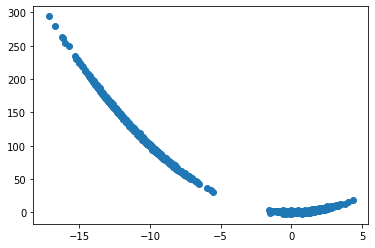

In [122]:
plt.scatter(A,B)

In [10]:
fo=open("../LinearDifferentvalues/testing_writingvalues_Linear0to1.txt", "r")
L=[]
A=[]
B=[]
#fe=open("dataset_params.txt",'w')
for i in range(0,121):
    line=fo.readline()
    #fe.write(line)
    #line=line[1:-2] #remove double quotes 
    #param = [j for j in line.split()]
    #print(param)
    #chrname.append(param[1])
    #g1.append(param[2])
    #g2.append(param[3])
    line=fo.readline()
    l = [j for j in line.split()]
    L.append([int(i) for i in l])
    line=fo.readline()
    a = [j for j in line.split()]
    A.append([float(i) for i in a])
    line=fo.readline()
    b = [j for j in line.split()]
    B.append([float(i) for i in b])
dataset_linear = [i for i in zip(L,A,B)]
fo.close()
#fe.close()

In [12]:
len(dataset_linear)

121

In [13]:
fer=open("../LinearDifferentvalues/dataset_params_Linear0to1.txt","r")
dataset_names=[]
for i in range(0,121):
    line=fer.readline()
    line="_".join(line.split())
    dataset_names.append(line)
fer.close()

In [15]:
dataset_names[24]

'0.3_0.3'

In [20]:
def calculate_pvalue(original,loss_list):
    '''
    calculate the p value 
    '''
    return sum(i < original for i in loss_list)/len(loss_list)
    
    

In [19]:
def compute_third_testloss(A,B):
    opt = tf.optimizers.Adam(1e-2)
    mdn_PQ = MDN_module()
    mdn_PQ.compile(loss=gnll_loss, optimizer=opt)
##changing epochs didnt make much difference

#mdn_PQ.fit(x=C, y=np.array(B).T,epochs=300,  batch_size=64)
    withoutL=mdn_PQ.fit(x=A, y=B.T,epochs=100,  batch_size=64,verbose=0)
    y_pred = mdn_PQ.predict(A)
    alpha,mu,sigma = slice_parameter_vectors(y_pred)
    gm = tfd.MixtureSameFamily(
        mixture_distribution=tfd.Categorical(probs=alpha),
        components_distribution=tfd.Normal(
            loc=mu,       
            scale=sigma))
    log_likelihood = gm.log_prob(B).numpy()
    return -tf.reduce_mean(log_likelihood, axis=-1).numpy()

In [18]:
def calculate_difference(L,A,B):
    return compute_third_testloss(reshapevar(A),np.array(B))-compute_third_testloss(np.concatenate([L.reshape(-1,1),A.reshape(-1,1)],axis=1),np.array(B))
    

In [17]:
def stratify_B_n_times_diff(L,A,B,n):
    loss=[]
    indices_1 = [i for i, x in enumerate(L) if x == 1]
    #changin x==0 to x=-1
    indices_0 = [i for i, x in enumerate(L) if x == 0]
    for i in range(0,n):
        B_dist_temp=np.zeros(len(B))
        mod_indices_1=random.sample(indices_1,len(indices_1))
        for i in range(len(indices_1)):
            B_dist_temp[indices_1[i]]=B[mod_indices_1[i]]

        mod_indices_0=random.sample(indices_0,len(indices_0))
        for i in range(len(indices_0)):
            B_dist_temp[indices_0[i]]=B[mod_indices_0[i]]
        loss.append(calculate_difference(L,A,B_dist_temp))
    return loss

In [26]:
    i=24
    A=np.array(dataset_linear[i][1])
    B=np.array(dataset_linear[i][2])
    L=np.array(dataset_linear[i][0])
    shuffles=10
    A_shuffle=np.copy(A)
    B_shuffle=np.copy(B)
    #print("Original",B_shuffle)
    #changed the second test from mle to using neural networks
    loss_list_LA=shuffleBtimes(L,A_shuffle,shuffles,True)
    loss_list_LB=shuffleBtimes(L,B_shuffle,shuffles,True)
    loss_list_Bresidual=stratify_B_n_times_diff(L,A_shuffle,B_shuffle,shuffles) #conditional independence test
    true_LA=compute_loss(L,A,True)
    true_LB=compute_loss(L,B,True)
    true_LBresidual=calculate_difference(L,A,B)
    LA_p=calculate_pvalue(true_LA,loss_list_LA)
    LB_p=calculate_pvalue(true_LB,loss_list_LB)
    AB_p=calculate_pvalue(true_LBresidual,loss_list_Bresidual)
    #f.write(str(i)+","+str(LA_p)+","+str(LB_p)+","+str(AB_p)+"\n")
    #pickle_items=[loss_list_LA,loss_list_LB,loss_list_Bresidual,true_LA,true_LB,true_LBresidual,LA_p,LB_p,AB_p]
    #file_name=str(dataset_names[i])+".pkl"
    #open_file = open("./DLresultspickle/"+file_name, "wb")
    #pickle.dump(pickle_items, open_file)
    #open_file.close()

2022-07-20 16:59:51.098703: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-07-20 16:59:51.098737: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-07-20 16:59:51.098756: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (birds05-Precision-Tower-3620): /proc/driver/nvidia/version does not exist
2022-07-20 16:59:51.116534: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [27]:
#print(dataset_names[120])
print(LA_p)
print(LB_p)
print(AB_p)

0.0
0.0
0.4


In [32]:
loss_list_LB

[1.460673089567857,
 1.4602832304211348,
 1.4606215430903624,
 1.460701236985601,
 1.4603112463100398,
 1.460742775266244,
 1.460517507338415,
 1.4605780198332896,
 1.4595929775892673,
 1.4597127737722275]

In [44]:
true_LBresidual

0.011517048

In [45]:
loss_list_Bresidual

[0.011733532,
 0.010611057,
 0.012115121,
 0.012776256,
 0.01239872,
 0.0068571568,
 0.01448679,
 0.006354451,
 0.006739974,
 0.013059139]

In [56]:
A=A.reshape((1000,1))

In [57]:
B=B.reshape((1000,1))

In [58]:
L=L.reshape((1000,1))

In [66]:
CCIT.CCIT(L,B,A,num_iter = 30, bootstrap = True, nthread = 20) 

1.276148102341348e-15

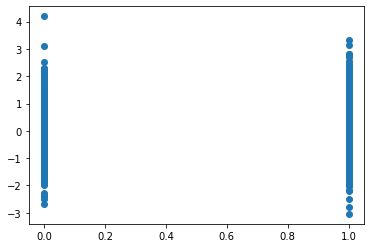

In [47]:
plt.scatter(L,B)

In [33]:
i=120
#A=np.array(dataset_linear[i][1])
#B=np.array(dataset_linear[i][2])
#L=np.array(dataset_linear[i][0])
opt = tf.optimizers.Adam(1e-2)
mdn_PQ = MDN_module()
mdn_PQ.compile(loss=gnll_loss, optimizer=opt)
withoutL=mdn_PQ.fit(x=np.concatenate([L.reshape(-1,1),A.reshape(-1,1)],axis=1), y=B.T,epochs=100,  batch_size=64,verbose=0)
y_pred = mdn_PQ.predict(np.concatenate([L.reshape(-1,1),A.reshape(-1,1)],axis=1))


Text(0.5, 1.0, 'Original data with added information of L')

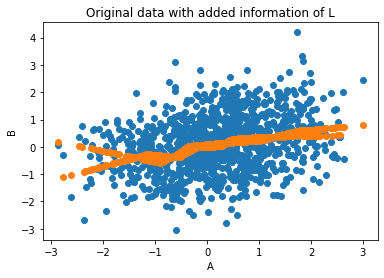

In [34]:
plt.scatter(A,B)
plt.scatter(A,y_pred[:,1])
plt.xlabel("A")
plt.ylabel("B")
plt.title("Original data with added information of L")

In [27]:
L = np.random.binomial(1,0.5,1000)  
eps0 = np.random.normal(0,0.1,1000)
eps1 = np.random.normal(0,0.1,1000)
A = 1*L + eps0
#B=beta2+beta3*np.sin(A)+eps1
B =1*A + eps1 

In [35]:
i=39
#A=np.array(dataset_linear[i][1])
#B=np.array(dataset_linear[i][2])
#L=np.array(dataset_linear[i][0])
opt = tf.optimizers.Adam(1e-2)
mdn_PQ = MDN_module()
mdn_PQ.compile(loss=gnll_loss, optimizer=opt)
withoutL=mdn_PQ.fit(x=reshapevar(A), y=B.T,epochs=100,  batch_size=64,verbose=0)
y_pred = mdn_PQ.predict(reshapevar(A))


Text(0.5, 1.0, 'Original data without the added information')

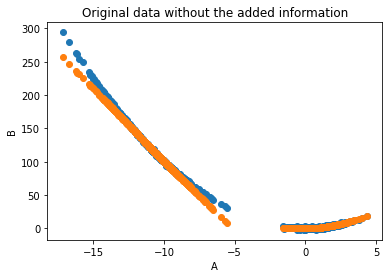

In [128]:
plt.scatter(A,B)
plt.scatter(A,y_pred[:,1])
plt.xlabel("A")
plt.ylabel("B")
plt.title("Original data without the added information")


In [36]:
indices_1 = [i for i, x in enumerate(L) if x == 1]
indices_0 = [i for i, x in enumerate(L) if x == 0]
#indices_2 = [i for i, x in enumerate(L) if x == -1]
B_dist_temp=np.zeros(len(B))
mod_indices_1=random.sample(indices_1,len(indices_1))
for i in range(len(indices_1)):
    B_dist_temp[indices_1[i]]=B[mod_indices_1[i]]

mod_indices_0=random.sample(indices_0,len(indices_0))
for i in range(len(indices_0)):
    B_dist_temp[indices_0[i]]=B[mod_indices_0[i]]
#mod_indices_2=random.sample(indices_2,len(indices_2))
#for i in range(len(indices_2)):
#    B_dist_temp[indices_2[i]]=B[mod_indices_2[i]]

In [129]:
indices_1 = [i for i, x in enumerate(L) if x == 1]
indices_0 = [i for i, x in enumerate(L) if x == -1]
B_dist_temp=np.zeros(len(B))
mod_indices_1=random.sample(indices_1,len(indices_1))
for i in range(len(indices_1)):
    B_dist_temp[indices_1[i]]=B[mod_indices_1[i]]

mod_indices_0=random.sample(indices_0,len(indices_0))
for i in range(len(indices_0)):
    B_dist_temp[indices_0[i]]=B[mod_indices_0[i]]

In [37]:
B_dist_temp

array([ 4.64272508e-01, -6.72118413e-01,  1.23743249e-01,  4.42534580e-01,
       -2.87350788e-01, -1.45635258e+00,  3.75577108e-01, -1.18107416e+00,
       -1.02360806e+00, -6.88692698e-01, -1.57612197e+00,  7.47027117e-01,
        1.99266800e+00,  9.69020658e-01,  7.04530452e-01,  3.34241646e-01,
       -5.94478511e-01, -3.70997581e-01, -1.24129501e-01, -1.75279115e+00,
       -5.69569250e-01,  8.77806356e-01,  9.06322597e-01,  2.14091027e-01,
       -1.20428095e+00,  2.52791641e+00, -1.48846449e+00, -1.09476365e+00,
       -4.70654344e-01, -1.91735197e-01, -1.55231016e+00,  4.86099067e-01,
       -1.97222396e+00, -1.55002421e+00, -7.94361367e-01, -6.99895795e-01,
       -1.52163913e+00, -1.01653133e+00, -1.21111804e+00, -6.59684971e-02,
        9.49137451e-01, -3.32707159e-01, -1.75510043e+00,  7.13088259e-01,
        1.67367491e-01,  1.97734991e-01, -4.62660099e-01,  5.05088965e-01,
       -4.21186820e-01, -5.67391306e-01,  1.87510905e+00, -4.89686522e-01,
       -1.50450684e+00,  

In [38]:
opt = tf.optimizers.Adam(1e-2)
mdn_PQ = MDN_module()
mdn_PQ.compile(loss=gnll_loss, optimizer=opt)
withoutL=mdn_PQ.fit(x=np.concatenate([L.reshape(-1,1),A.reshape(-1,1)],axis=1), y=B_dist_temp.T,epochs=100,  batch_size=64,verbose=0)
y_pred = mdn_PQ.predict(np.concatenate([L.reshape(-1,1),A.reshape(-1,1)],axis=1))


Text(0.5, 1.0, 'Permuted data with the added information L')

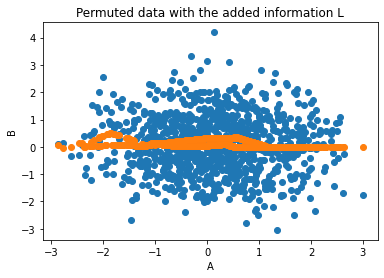

In [39]:
plt.scatter(A,B_dist_temp)
plt.scatter(A,y_pred[:,1])
plt.xlabel("A")
plt.ylabel("B")
plt.title("Permuted data with the added information L")

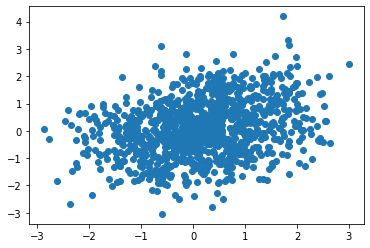

In [42]:
plt.scatter(A,B)

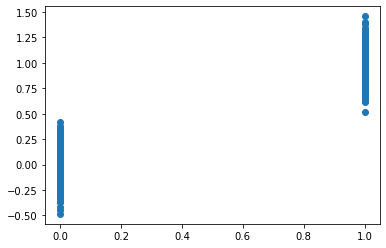

In [36]:
plt.scatter(L,B_dist_temp)

In [74]:
y_pred[:,1]

array([ 0.16635783,  0.2186405 ,  0.18518928,  0.10589456,  0.17865732,
       -0.35579273, -0.04156049,  0.12228131, -0.09812831,  0.09319367,
        0.3773023 , -0.16365555, -0.16234308, -0.16900453,  0.12274399,
       -0.15720737, -0.28126025, -0.16225696, -0.17248657,  0.32775828,
       -0.15370303,  0.16625354, -0.1993328 ,  0.17074063, -0.00772212,
        0.49461097,  0.11442166, -0.15977705, -0.22537157,  0.41071504,
       -0.16241938,  0.44264197,  0.17576036,  0.05727377, -0.3367372 ,
       -0.17105737,  0.29478714,  0.17676872,  0.16581364,  0.09946011,
        0.145416  ,  0.17023754, -0.16416475,  0.17091137,  0.10237812,
       -0.16080457,  0.21831697,  0.10226455,  0.0290572 ,  0.1795223 ,
       -0.22151831,  0.17676303, -0.17321783,  0.19708046,  0.11806276,
        0.28889436, -0.12351852, -0.22434738, -0.0246013 ,  0.19793275,
       -0.36712444,  0.45668212, -0.1871123 , -0.10708769,  0.06748994,
        0.12040724,  0.37059048, -0.3023749 ,  0.18500692,  0.16

In [40]:
opt = tf.optimizers.Adam(1e-2)
mdn_PQ = MDN_module()
mdn_PQ.compile(loss=gnll_loss, optimizer=opt)
withoutL=mdn_PQ.fit(x=reshapevar(A), y=B_dist_temp.T,epochs=64,  batch_size=10,verbose=0)
y_pred = mdn_PQ.predict(reshapevar(A))

Text(0.5, 1.0, 'Permuted data without the added information')

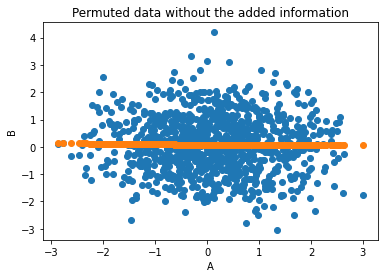

In [41]:
plt.scatter(A,B_dist_temp)
plt.scatter(A,y_pred[:,1])
plt.xlabel("A")
plt.ylabel("B")
plt.title("Permuted data without the added information")

In [50]:
L = np.random.binomial(1,0.5,1000)  
#eps0 = np.random.standard_normal(1000)
#eps1 = np.random.standard_normal(1000)
eps0 = np.random.normal(-2,0.5,1000)
eps1 = np.random.normal(-5,0.5,1000)
A=9*L - eps0
B=8*np.sin(A)+eps1

In [51]:
indices_1 = [i for i, x in enumerate(L) if x == 1]
indices_0 = [i for i, x in enumerate(L) if x == 0]

Text(0, 0.5, 'A')

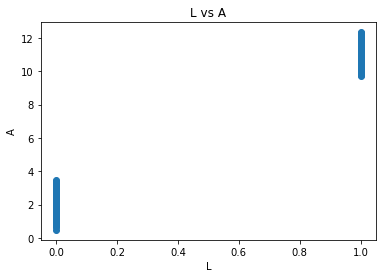

In [52]:
plt.scatter(L,A)
plt.title("L vs A")
plt.xlabel("L")
plt.ylabel("A")

Text(0, 0.5, 'B')

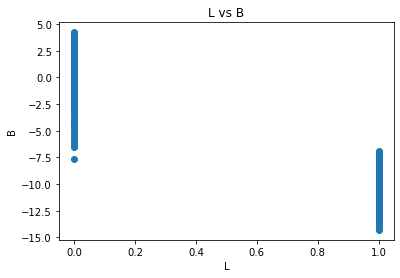

In [53]:
plt.scatter(L,B)
plt.title("L vs B")
plt.xlabel("L")
plt.ylabel("B")

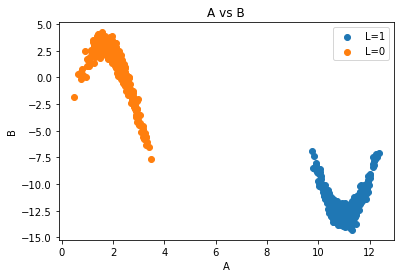

In [54]:
plt.scatter(A[indices_1],B[indices_1],label="L=1")
plt.scatter(A[indices_0],B[indices_0],label="L=0")
plt.title("A vs B")
plt.xlabel("A")
plt.ylabel("B")
plt.legend()

Text(0, 0.5, 'B')

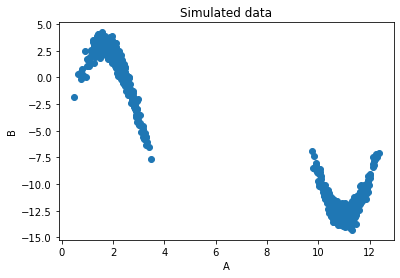

In [55]:
plt.scatter(A,B)
plt.title("Simulated data")
plt.xlabel("A")
plt.ylabel("B")

In [151]:
str(pearsonr(A,B)[0])

'0.07270086408772637'

In [57]:
f = open("testing_writingvalues_debugSine.txt", "w")
f.write(str(9)+" "+ str(8))
f.write("\n")
np.savetxt(f,L,newline=' ',fmt='%s')
f.write("\n")
np.savetxt(f,A,newline=' ',fmt='%s')
f.write("\n")
np.savetxt(f,B,newline=' ',fmt='%s')
f.write("\n")
f.close()
